In [1]:
import pandas as pd

In [2]:
pd.__version__

'1.4.2'

In [3]:
!pip install pyarrow


     |████████████████████████████████| 42.3 MB 9.8 kB/s eta 0:00:01


In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [5]:
df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
import pickle

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
import sklearn

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [13]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

raw_duration_std = df['duration'].std()
print(f"Standard deviation of trip durations in January (before filtering): {raw_duration_std:.2f} minutes")


Standard deviation of trip durations in January (before filtering): 42.59 minutes


In [2]:
total_records = len(df)
print("\nSummary statistics of durations (unfiltered):")
print(df['duration'].describe())
print(f"Total records before filtering: {total_records}")
print(f"Negative durations: {len(df[df['duration'] < 0])}")
print(f"Zero durations: {len(df[df['duration'] == 0])}")
print(f"Durations > 60 minutes: {len(df[df['duration'] > 60])}")

NameError: name 'df' is not defined

In [17]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [18]:
filtered_records = len(df)

# Calculate fraction of records remaining
fraction_remaining = filtered_records / total_records
percentage_remaining = fraction_remaining * 100

# Print results
print(f"\nRecords after filtering (1–60 minutes): {filtered_records}")
print(f"Fraction of records remaining: {fraction_remaining:.4f}")
print(f"Percentage of records remaining: {percentage_remaining:.2f}%")


Records after filtering (1–60 minutes): 3009173
Fraction of records remaining: 0.9812
Percentage of records remaining: 98.12%


In [22]:
import numpy as np

In [20]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


# Get dimensionality (number of columns)
num_columns = X_train.shape[1]

# Print results
print(f"Number of records: {len(df)}")
print(f"Dimensionality of the feature matrix (number of columns): {num_columns}")
# print(f"Feature names (first 10): {dv.feature_names_[:100]}")


Number of records: 3009173
Dimensionality of the feature matrix (number of columns): 516


In [21]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

# root_mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))

In [23]:
print(rmse)

7.649143388169879


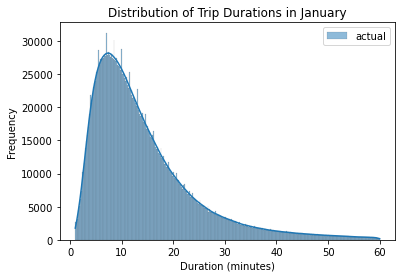

In [24]:
sns.histplot(df['duration'], kde=True, label='actual')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations in January')
plt.legend()
plt.show()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


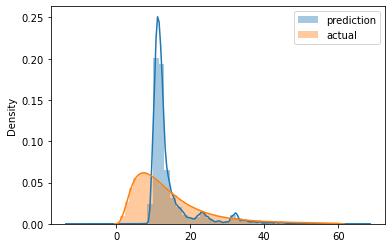

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [28]:
len(df_train), len(df_val)

(3009173, 2855951)

In [29]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [1]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

NameError: name 'df_train' is not defined

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
print(rmse)

In [ ]:
import os

os.makedirs('models', exist_ok=True)  # Create folder if not exists

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
print(rmse)